In [1]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as pl
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM

2023-06-02 16:32:13.388894: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 16:32:13.460566: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-02 16:32:14.639713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# loading the data
df = pd.read_csv('final_dataframe.csv')

In [3]:
print(df.shape)
df.head()

(28826, 187)


,center_0_X,center_0_Y,center_1_X,center_1_Y,obj_class,obj_X,obj_Y,obj_width,obj_height,landmark_0_0_X,...,L_Reach,L_Grasp,L_Manipulation,L_Transport,L_Place,R_Reach,R_Grasp,R_Manipulation,R_Transport,R_Place
0,195.091320,199.277472,0.000000,0.000000,4.0,0.0,0.0,1.0,1.0,203.6780,...,0,0,0,0,0,0,0,0,0,0
1,208.651174,179.422023,0.000000,0.000000,4.0,0.0,0.0,1.0,1.0,210.2895,...,0,0,0,0,0,0,0,0,0,0
2,90.084400,129.034737,0.000000,0.000000,4.0,300.0,300.0,1.0,1.0,95.7721,...,0,0,0,0,0,0,0,0,0,0
3,168.386314,161.723760,217.941821,175.335138,4.0,0.0,0.0,1.0,1.0,166.9457,...,0,0,0,0,0,0,0,0,0,0
4,242.268548,193.365412,0.000000,0.000000,4.0,0.0,0.0,1.0,1.0,236.6061,...,0,0,0,0,0,0,0,0,0,0


# Dataframe modification
Since the submovement classification models give us terrible result, I want to try to change the problem to a simple binary problem.
I just want to check if I am able to detect if there is a submovement on the frame or if the is no submovement to detect at all.

In [4]:
# create a new dataframe with only one label per frame (if there is a submovent or not)
df_binary = df.copy()

# add a new column to the dataframe with the label 1 if there is a submovent and 0 if there is not
df_binary['submovemet'] = 0

for row in range(len(df_binary)):
    if sum(df_binary.iloc[row, -10:]) == 0:
        df_binary.iloc[row, -1] = 0
    else:
        df_binary.iloc[row, -1] = 1

# drop the columns with the labels of the submovents
df_binary = df_binary.drop(df_binary.columns[-11:-1], axis=1)

print(df_binary.shape)
df_binary.tail()

(28826, 178)


,center_0_X,center_0_Y,center_1_X,center_1_Y,obj_class,obj_X,obj_Y,obj_width,obj_height,landmark_0_0_X,...,dist_1_12,dist_1_13,dist_1_14,dist_1_15,dist_1_16,dist_1_17,dist_1_18,dist_1_19,dist_1_20,submovemet
28821,216.243939,167.307061,0.000000,0.000000,4.0,0.0000,0.0000,1.0000,1.0000,200.7097,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
28822,285.279247,96.885535,0.000000,0.000000,4.0,0.0000,300.0000,1.0000,1.0000,275.6823,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,1
28823,223.838049,151.259000,0.000000,0.000000,43.0,178.8282,180.2343,11.7188,56.7189,240.1237,...,253.897475,253.897475,253.897475,253.897475,253.897475,253.897475,253.897475,253.897475,253.897475,1
28824,249.500624,192.641079,185.496440,166.445103,43.0,178.8282,181.1718,11.7188,56.7189,270.4019,...,33.183906,19.759427,24.042625,25.951690,25.881833,14.237091,18.065996,19.488584,18.575360,1
28825,187.115064,224.444779,296.414813,122.149576,43.0,178.5936,182.1093,11.2500,57.6564,167.1067,...,152.600011,136.089019,143.842538,147.712508,150.577753,135.713411,142.263609,145.986072,148.625621,1


In [5]:
# get all the frame with no submovement
df_without_submovement = df_binary[df_binary['submovemet'] == 0]
print(df_without_submovement.shape)

# get the same number of frames with submovements
df_with_submovement = df_binary[df_binary['submovemet'] == 1].sample(n=len(df_without_submovement), random_state=42)

# concatenate the two dataframes
df_binary = pd.concat([df_with_submovement, df_without_submovement])

# shuffle the dataframe
df_binary = df_binary.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_binary.shape)

(2072, 178)
(4144, 178)


In [6]:
# create a copy of the dataframe before dropping some columns
df_copy = df_binary.copy()

# drop the object class column (it is not a pixel value and it is not needed for the model)
df_copy = df_copy.drop(['obj_class'], axis=1)

df_copy.head()

,center_0_X,center_0_Y,center_1_X,center_1_Y,obj_X,obj_Y,obj_width,obj_height,landmark_0_0_X,landmark_0_0_Y,...,dist_1_12,dist_1_13,dist_1_14,dist_1_15,dist_1_16,dist_1_17,dist_1_18,dist_1_19,dist_1_20,submovemet
0,176.129318,190.824809,0.000000,0.000000,111.0939,116.4843,8.4375,22.9688,171.7985,208.9730,...,160.967223,160.967223,160.967223,160.967223,160.967223,160.967223,160.967223,160.967223,160.967223,0
1,0.000000,0.000000,0.000000,0.000000,256.8750,173.4375,45.0000,35.6250,0.0000,0.0000,...,309.944079,309.944079,309.944079,309.944079,309.944079,309.944079,309.944079,309.944079,309.944079,1
2,201.508151,189.034878,0.000000,0.000000,0.0000,0.0000,1.0000,1.0000,203.9814,211.2813,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,173.339013,191.439031,247.027602,147.297658,147.8907,139.2189,37.9689,35.6250,159.7721,199.5169,...,79.009980,95.074517,86.329393,83.538863,80.996095,98.147480,91.011774,88.197604,85.508150,1
4,0.000000,0.000000,0.000000,0.000000,169.4532,158.9064,65.1561,51.5625,0.0000,0.0000,...,232.305039,232.305039,232.305039,232.305039,232.305039,232.305039,232.305039,232.305039,232.305039,1


In [7]:
df_copy.shape

(4144, 177)

### check the number of frame which actually have hands AND object detected

In [8]:
# get all the columns which are distance measurements
distance_columns = [col for col in df_copy.columns if 'dist' in col]
not_valid_frames = []
nb_not_valid_frames = 0

# for each row, the first distance column value should not be 0
for index, row in df_copy.iterrows():
    if row[distance_columns[0]] == 0.0:
        not_valid_frames.append(index)
        nb_not_valid_frames += 1

print("There is only {} valids rows".format(df_copy.shape[0] - nb_not_valid_frames))

# drop the not valid rows (the ones with a 0.0 value for the first distance column)
df_copy = df_copy.drop(not_valid_frames, axis=0)

df_copy.shape

There is only 4144 valids rows


(4144, 177)

# Model creation

### Grid search

In [16]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

features = df_copy.iloc[:, :175].values
labels = df_copy.iloc[:, 176:].values

print(features.shape)
print(labels.shape)

# Divide the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Normalisazion of the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model creation
def create_model(units=32, dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(units=units, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# KerasClassifier creation
model = KerasClassifier(build_fn=create_model)

# Specify the hyperparameter space
param_grid = {
    'units': [64, 128, 256],
    'dropout_rate': [0.3, 0.5],
    'batch_size': [16],
    'epochs': [100, 200]
}

# Run the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Show the best hyperparameters
print("Meilleurs hyperparamètres : ", grid_search.best_params_)
print("Meilleur score d'exactitude (accuracy) : ", grid_search.best_score_)

(4144, 175)
(4144, 1)
Epoch 1/100


/tmp/ipykernel_3825267/195669218.py:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)


139/139 [==============================] - 1s 3ms/step - loss: 0.7297 - accuracy: 0.5308
Epoch 2/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.5484
Epoch 3/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.5715
Epoch 4/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5733
Epoch 5/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6762 - accuracy: 0.5855
Epoch 6/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6693 - accuracy: 0.5760
Epoch 7/100
139/139 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.5878
Epoch 8/100
139/139 [==============================] - 0s 2ms/step - loss: 0.6644 - accuracy: 0.5905
Epoch 9/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6532 - accuracy: 0.6050
Epoch 10/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.5982
E

### CNN model

In [17]:
# Separate the features and the labels
features = df_copy.iloc[:, :175].values
labels = df_copy.iloc[:, 176:].values

print(features.shape)
print(labels.shape)

# Divide the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Normalisazion of the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model creation
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Model compilation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model training
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test))

# Model evaluation
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.round(y_test_pred_prob).flatten()

# Print the accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Exactitude (accuracy) du modèle sur l'ensemble de test : ", test_accuracy)

(4144, 175)
(4144, 1)
Epoch 1/200
208/208 [==============================] - 2s 5ms/step - loss: 0.7472 - accuracy: 0.5424 - val_loss: 0.6725 - val_accuracy: 0.5669
Epoch 2/200
208/208 [==============================] - 1s 4ms/step - loss: 0.6933 - accuracy: 0.5629 - val_loss: 0.6685 - val_accuracy: 0.5850
Epoch 3/200
208/208 [==============================] - 1s 2ms/step - loss: 0.6853 - accuracy: 0.5735 - val_loss: 0.6641 - val_accuracy: 0.5911
Epoch 4/200
208/208 [==============================] - 1s 3ms/step - loss: 0.6721 - accuracy: 0.5861 - val_loss: 0.6525 - val_accuracy: 0.6164
Epoch 5/200
208/208 [==============================] - 1s 3ms/step - loss: 0.6674 - accuracy: 0.6018 - val_loss: 0.6641 - val_accuracy: 0.5645
Epoch 6/200
208/208 [==============================] - 1s 4ms/step - loss: 0.6641 - accuracy: 0.6063 - val_loss: 0.6411 - val_accuracy: 0.6236
Epoch 7/200
208/208 [==============================] - 1s 4ms/step - loss: 0.6627 - accuracy: 0.6021 - val_loss: 0.6448 

In [11]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


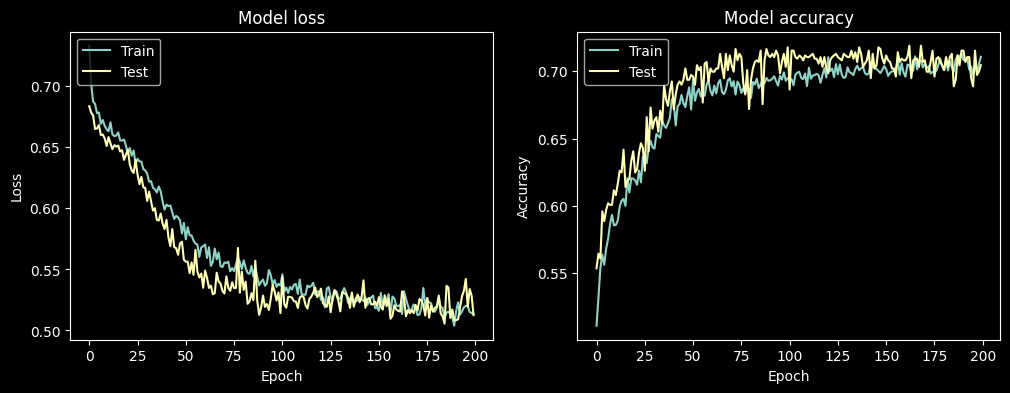

In [12]:
# plot accuray and loss curves for validation and test sets
pl.figure(figsize=(12, 4))
pl.subplot(1, 2, 1)
pl.plot(history.history['loss'])
pl.plot(history.history['val_loss'])
pl.title('Model loss')
pl.ylabel('Loss')
pl.xlabel('Epoch')
pl.legend(['Train', 'Test'], loc='upper left')
pl.subplot(1, 2, 2)
pl.plot(history.history['accuracy'])
pl.plot(history.history['val_accuracy'])
pl.title('Model accuracy')
pl.ylabel('Accuracy')
pl.xlabel('Epoch')
pl.legend(['Train', 'Test'], loc='upper left')
pl.show()



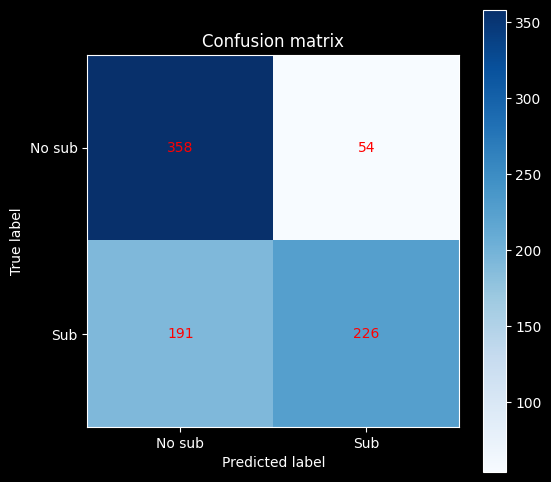

In [13]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
pl.figure(figsize=(6, 6))
pl.imshow(cm, cmap=pl.cm.Blues)
pl.colorbar()
pl.title('Confusion matrix')
pl.xlabel('Predicted label')
pl.ylabel('True label')
pl.xticks([0, 1], ['No sub', 'Sub'])
pl.yticks([0, 1], ['No sub', 'Sub'])
for i in range(2):
    for j in range(2):
        pl.text(j, i, cm[i, j], ha='center', va='center', color='red')
pl.show()


### SVM : One vs Rest model

In [14]:
# Séparer les caractéristiques (paramètres de détection) et les étiquettes (classes de sous-mouvements)
features = df_copy.iloc[:, :175].values
labels = df_copy.iloc[:, 176:].values

print(features.shape)
print(labels.shape)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Normaliser les caractéristiques pour améliorer la performance du SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Créer un classifieur SVM
clf = svm.SVC(kernel='linear')

# Entraîner le modèle SVM
clf.fit(X_train, y_train)

# Prédire les étiquettes pour les données de test
y_pred = clf.predict(X_test)

# Calculer l'exactitude (accuracy) du modèle
accuracy = accuracy_score(y_test, y_pred)
print("SVM accuracy : ", accuracy)

(4144, 175)
(4144, 1)


/home/sam.corpatau/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM accuracy :  0.6369119420989143


26/26 [==============================] - 0s 1ms/step


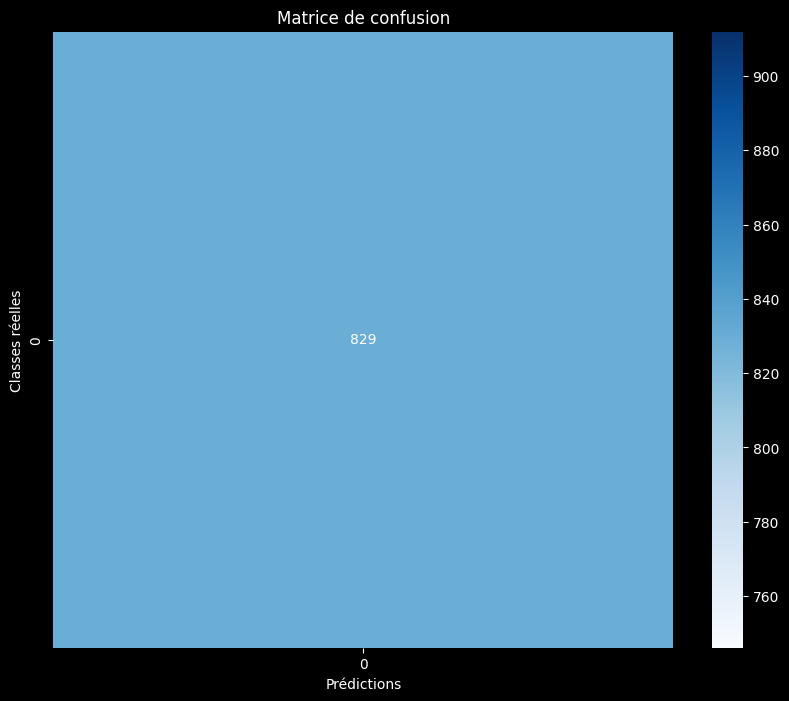

Model accuracy :  1.0


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# validation set prediction
y_test_pred = model.predict(X_test)

# conversion of predictions to class labels
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# calculate confusion matrix
confusion_mat = confusion_matrix(y_test_true_classes, y_test_pred_classes)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Classes réelles')
plt.title('Matrice de confusion')
plt.show()

# calculate accuracy on validation set
accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes)
print("Model accuracy : ", accuracy)